In [2]:
import pandas as pd
import os
import xarray as xr

## Data Reading

In [3]:
df_mapping = pd.read_csv("../../data/processed/mapping/no2_to_traffic_sensor_mapping.csv")

df_air = pd.read_parquet("../../data/processed/air/df_air_quality_and_locations_from_2013.parquet")

Read traffic data

In [4]:
# Define the root directory for processed traffic data
root_dir = '../../data/processed/traffic'

# List to hold DataFrames
dataframes = []

# Iterate through all folders in the root directory
for folder_name in os.listdir(root_dir):
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the folder exists and is a directory
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_path}")
        
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.parquet'):  # Ensure it's a Parquet file
                file_path = os.path.join(folder_path, file_name)
                
                # Read the Parquet file
                try:
                    df = pd.read_parquet(file_path)
                    print(f"Successfully read: {file_path} with {len(df)} rows.")
                    
                    # Append the DataFrame to the list
                    dataframes.append(df)
                    
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")

# Concatenate all DataFrames into one
if dataframes:  # Check if the list is not empty
    df_traffic = pd.concat(dataframes, ignore_index=True)
    print(f"Combined DataFrame created with {len(df_traffic)} rows.")

Processing folder: ../../data/processed/traffic/2022
Successfully read: ../../data/processed/traffic/2022/12-2022_processed.parquet with 48331 rows.
Successfully read: ../../data/processed/traffic/2022/11-2022_processed.parquet with 46722 rows.
Successfully read: ../../data/processed/traffic/2022/10-2022_processed.parquet with 47576 rows.
Successfully read: ../../data/processed/traffic/2022/01-2022_processed.parquet with 45047 rows.
Successfully read: ../../data/processed/traffic/2022/06-2022_processed.parquet with 42196 rows.
Successfully read: ../../data/processed/traffic/2022/05-2022_processed.parquet with 42735 rows.
Successfully read: ../../data/processed/traffic/2022/08-2022_processed.parquet with 45087 rows.
Successfully read: ../../data/processed/traffic/2022/02-2022_processed.parquet with 40460 rows.
Successfully read: ../../data/processed/traffic/2022/03-2022_processed.parquet with 44372 rows.
Successfully read: ../../data/processed/traffic/2022/09-2022_processed.parquet with

In [5]:
# Define the root directory for processed traffic data
root_dir = '../../data/raw/meteo'

# List to hold DataFrames
dataframes = []

# Iterate through all folders in the root directory
for folder_name in ['2018']:
    folder_path = os.path.join(root_dir, folder_name)
    
    # Check if the folder exists and is a directory
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_path}")
        
        # Iterate through all files in the folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.grib'):  # Ensure it's a Parquet file
                file_path = os.path.join(folder_path, file_name)
                
                # Read the Parquet file
                try:                    
                    df = xr.open_dataset(file_path, engine='cfgrib',  backend_kwargs={'indexpath': None})
                    print(f"Successfully read: {file_path} with {len(df)} rows.")
                    
                    df = df.to_dataframe().reset_index()  # Reset index if needed
                    df = df[df['d2m'].notna()]
                    
                    # Append the DataFrame to the list
                    dataframes.append(df)
                    
                except Exception as e:
                    print(f"Error reading file {file_name}: {e}")

# Concatenate all DataFrames into one
if dataframes:  # Check if the list is not empty
    df_meteo = pd.concat(dataframes, ignore_index=True)
    print(f"Combined DataFrame created with {len(df_meteo)} rows.")

Processing folder: ../../data/raw/meteo/2018
Successfully read: ../../data/raw/meteo/2018/e99341ff3b7b94cae8e3ecd140fdd177.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/5e57992aac2ac56b7162ae01d706101c.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/979398cb4826898b688f868f8f6df5b.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/6d41aa349ea12967aa10013f34ffc380.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/3626a5f630ed0e9abd392f0052295ec8.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/53007aea49134b417d72c70d96447ae5.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/495908a0213127247b17bf04990180f4.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/884cc40e96d15c88c1e35ae19ab85f77.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/64d6bf7ab4452798270cf18dc39bc54b.grib with 8 rows.
Successfully read: ../../data/raw/meteo/2018/646c1c43004891a3c55ed0ed2661f750.grib with 8 ro

## Data Cleaning

In [6]:
unnecesary_cols = ['PROVINCIA','MUNICIPIO','ESTACION','MAGNITUD','PUNTO_MUESTREO','CODIGO_CORTO','LOCALIZACION','DIRECCION','COD_VIA','COD_TIPO']

df_air = df_air.drop(columns = unnecesary_cols)
df_air.columns = df_air.columns.str.lower()
df_air = df_air.rename(columns = {'codigo':'id_no2'})

In [7]:
df_air['id_no2'] = df_air['id_no2'].astype(str)
df_mapping['id_trafico'] = df_mapping['id_trafico'].astype(str)
df_mapping['id_no2'] = df_mapping['id_no2'].astype(str)

In [8]:
df_traffic = df_traffic.rename(columns = {'hora': 'fecha'})

In [9]:
df_meteo = df_meteo.rename(columns = {'valid_time':'fecha'})
df_meteo = df_meteo.drop(columns = ['time','step','surface'])

keep only X coordinate (improve this in the future) Creating ethe mapping... TODO

In [10]:
df_meteo = df_meteo[(df_meteo['latitude'] == 40.7) & (df_meteo['longitude'] == -3.7)]

Joining the data

In [11]:
df = pd.merge(df_air, df_mapping, how = 'left', left_on='id_no2', right_on='id_no2')
df = pd.merge(df, df_traffic, how = 'inner', left_on=['id_trafico','fecha'], right_on=['id_trafico','fecha'])

In [12]:
df = pd.merge(df, df_meteo, how = 'inner', left_on=['fecha'], right_on=['fecha'])

In [14]:
df.to_parquet("test.parquet")

In [15]:
df

,id_no2,year,month,day,hour,no2_value,validacion,fecha,altitud,nom_tipo,...,longitude,number,d2m,t2m,ssr,ssrd,u10,v10,sp,tp
0,28079004,2017,12,31,24,9.0,V,2018-01-01 00:00:00,637,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,0.001730
1,28079004,2017,12,31,24,9.0,V,2018-01-01 00:00:00,637,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,0.001730
2,28079004,2017,12,31,24,9.0,V,2018-01-01 00:00:00,637,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,0.001730
3,28079004,2017,12,31,24,9.0,V,2018-01-01 00:00:00,637,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,0.001730
4,28079004,2017,12,31,24,9.0,V,2018-01-01 00:00:00,637,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,0.001730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449922,28079056,2018,12,30,23,104.0,V,2018-12-30 23:00:00,605,Urbana tráfico,...,-3.7,0,268.385010,275.884094,7913452.0,9417824.0,0.116336,-2.092300,93502.6250,0.000002
449923,28079056,2018,12,30,23,104.0,V,2018-12-30 23:00:00,605,Urbana tráfico,...,-3.7,0,268.385010,275.884094,7913452.0,9417824.0,0.116336,-2.092300,93502.6250,0.000002
449924,28079056,2018,12,30,23,104.0,V,2018-12-30 23:00:00,605,Urbana tráfico,...,-3.7,0,268.385010,275.884094,7913452.0,9417824.0,0.116336,-2.092300,93502.6250,0.000002
449925,28079056,2018,12,30,23,104.0,V,2018-12-30 23:00:00,605,Urbana tráfico,...,-3.7,0,268.385010,275.884094,7913452.0,9417824.0,0.116336,-2.092300,93502.6250,0.000002


## EDA for only sensor 5547

In [12]:
df = df[df['id_trafico'] == '5547']

In [13]:
df.head()

,id_no2,year,month,day,hour,no2_value,validacion,fecha,altitud,nom_tipo,...,longitude,number,d2m,t2m,ssr,ssrd,u10,v10,sp,tp
105803,28079011,2017,12,31,24,9.0,V,2018-01-01 00:00:00,709,Urbana tráfico,...,-3.7,0,273.673187,276.506439,3768168.0,4487476.0,2.247192,-0.371521,93330.9375,1.729608e-03
105811,28079011,2018,1,1,1,11.0,V,2018-01-01 01:00:00,709,Urbana tráfico,...,-3.7,0,273.590759,276.003845,0.0,0.0,1.985703,-0.143768,93371.0000,1.564622e-07
105819,28079011,2018,1,1,2,33.0,V,2018-01-01 02:00:00,709,Urbana tráfico,...,-3.7,0,273.204254,275.202545,0.0,0.0,1.864395,0.010361,93406.2500,3.129244e-07
105827,28079011,2018,1,1,3,27.0,V,2018-01-01 03:00:00,709,Urbana tráfico,...,-3.7,0,272.692902,274.174835,0.0,0.0,1.389847,0.224579,93431.5000,3.129244e-07
105835,28079011,2018,1,1,4,16.0,V,2018-01-01 04:00:00,709,Urbana tráfico,...,-3.7,0,271.834595,273.225281,0.0,0.0,1.324982,0.263718,93444.9375,3.129244e-07


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_no2(df, id, min_date, max_date):
    df_test = df[df['id_no2'] == id].copy()
    df_test['fecha'] = pd.to_datetime(df_test['fecha'])
    daily_data = df_test[(df_test['fecha'] >= pd.to_datetime(min_date)) & 
                         (df_test['fecha'] <= pd.to_datetime(max_date))]

    variables = ['intensidad', 'carga', 'ocupacion', 'd2m', 't2m', 'sst', 'ssrd', 'u10','v10','sp','tp']
    # Eliminar variables que no existen en el DataFrame
    variables = [var for var in variables if var in df.columns]

    n_plots = len(variables)
    n_rows = (n_plots + 1) // 2  # Número de filas necesarias para 2 columnas

    fig, axs = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))
    axs = axs.flatten()  # Convertir el arreglo 2D en 1D para facilitar la asignación

    for i, var in enumerate(variables):
        ax = axs[i]
        ax.plot(daily_data['fecha'], daily_data['no2_value'], 'bo-', label='NO2 Value')
        ax.set_ylabel('NO2 Value', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        ax.set_title(f'NO2 Value and {var.capitalize()}')
        ax.grid(True)

        ax_sec = ax.twinx()
        ax_sec.plot(daily_data['fecha'], daily_data[var], linestyle='--', color='r', marker='x', label=var)
        ax_sec.set_ylabel(var.capitalize(), color='r')
        ax_sec.tick_params(axis='y', labelcolor='r')

    # Eliminar cualquier subplot no utilizado
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


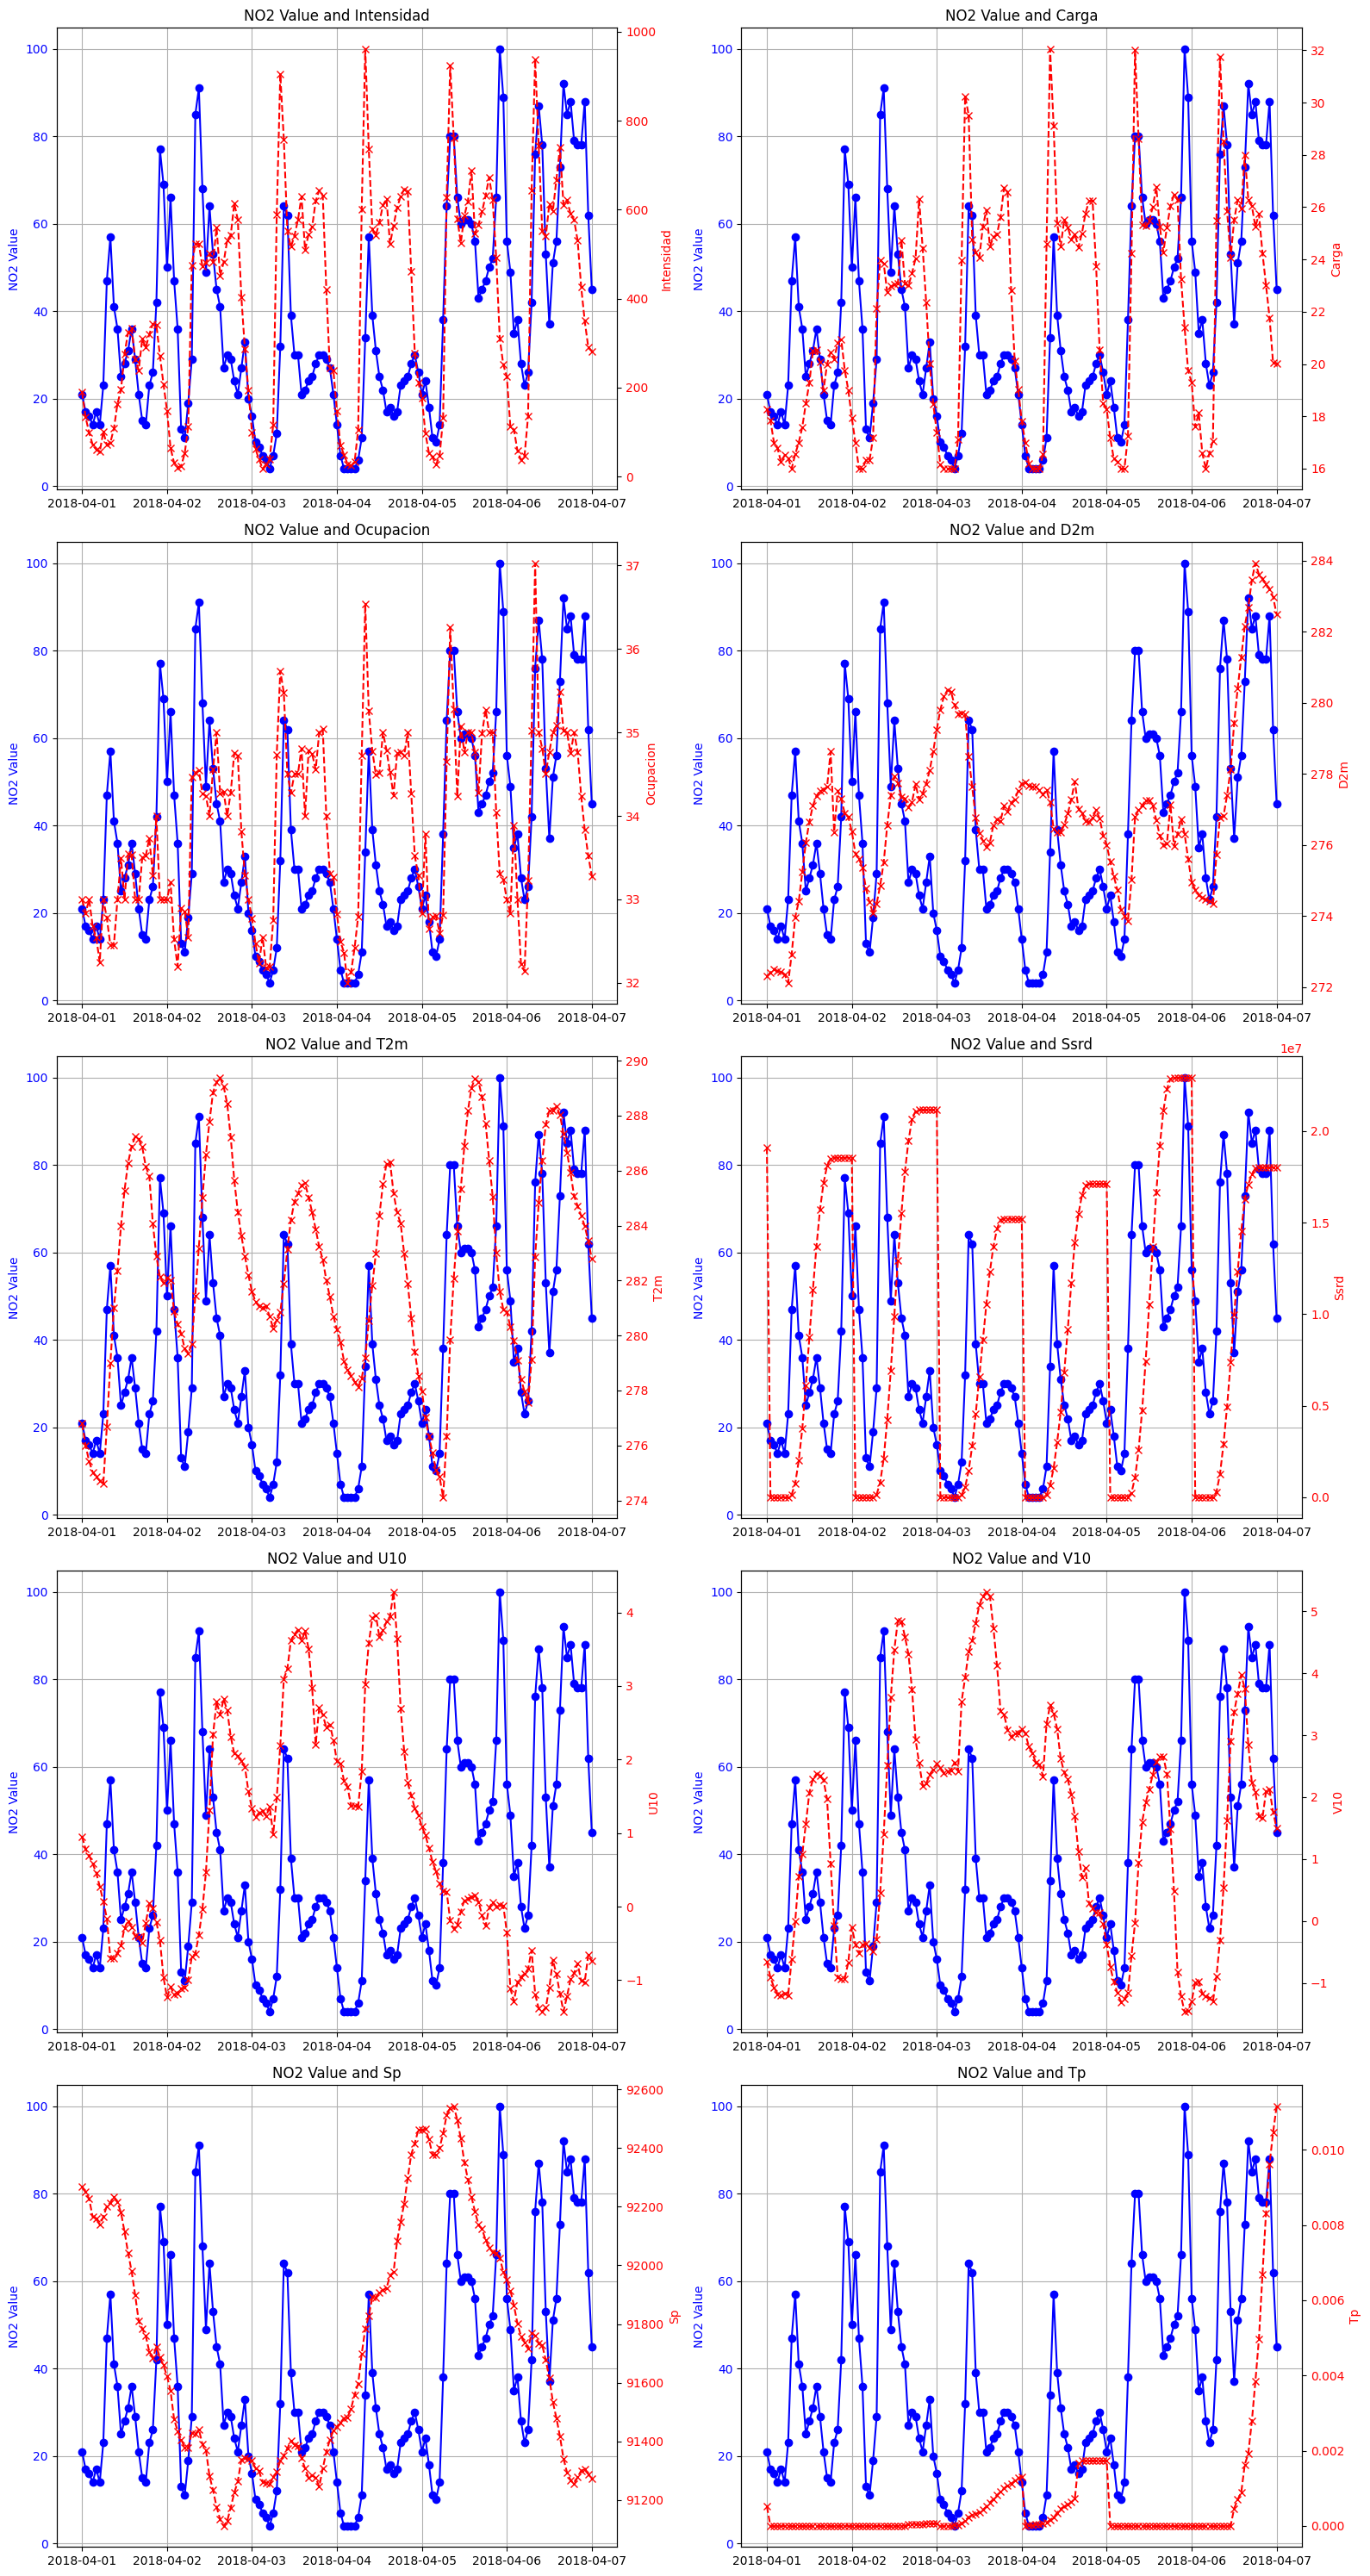

In [15]:
plot_no2(df, '28079011',min_date = '2018-04-01', max_date = '2018-04-07')

In [16]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.linear_model import LinearRegression
# import numpy as np

# def plot_no2(df, id, min_date, max_date):
#     df_test = df[df['id_no2'] == id].copy()
#     df_test['fecha'] = pd.to_datetime(df_test['fecha'])
#     daily_data = df_test[(df_test['fecha'] >= pd.to_datetime(min_date)) & 
#                          (df_test['fecha'] <= pd.to_datetime(max_date))]

#     variables = ['intensidad', 'carga', 'ocupacion', 'd2m', 't2m', 'sst', 'ssrd', 'u10','v10','sp','tp']
#     variables = [var for var in variables if var in df.columns]

#     # 1. Mapa de calor de correlación
#     corr_data = daily_data[['no2_value'] + variables]
#     corr_matrix = corr_data.corr()

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#     plt.title('Correlación entre NO2 y otras variables')
#     plt.show()

#     # 2. Gráficos de línea con colores diferenciados
#     n_plots = len(variables)
#     n_rows = (n_plots + 1) // 2
#     fig, axs = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))
#     axs = axs.flatten()

#     colors = sns.color_palette("Set2", n_colors=n_plots)  # Colores diferenciados

#     for i, var in enumerate(variables):
#         ax = axs[i]
#         ax.plot(daily_data['fecha'], daily_data['no2_value'], 'bo-', label='NO2 Value')
#         ax.set_ylabel('NO2 Value', color='b')
#         ax.tick_params(axis='y', labelcolor='b')
#         ax.set_title(f'NO2 Value vs {var.capitalize()}')
#         ax.grid(True)

#         ax_sec = ax.twinx()
#         ax_sec.plot(daily_data['fecha'], daily_data[var], linestyle='--', color=colors[i], marker='x', label=var)
#         ax_sec.set_ylabel(var.capitalize(), color=colors[i])
#         ax_sec.tick_params(axis='y', labelcolor=colors[i])

#     # Eliminar subgráficos vacíos
#     for j in range(i + 1, len(axs)):
#         fig.delaxes(axs[j])

#     plt.tight_layout()
#     plt.show()

#     # 3. Diagramas de dispersión (scatter plot) con regresión lineal
#     plt.figure(figsize=(16, 16))
#     for i, var in enumerate(variables):
#         plt.subplot(4, 3, i + 1)
#         sns.scatterplot(x=daily_data[var], y=daily_data['no2_value'], color=colors[i])
#         sns.regplot(x=daily_data[var], y=daily_data['no2_value'], scatter=False, color=colors[i])
#         plt.title(f'{var.capitalize()} vs NO2 Value')
#         plt.xlabel(var.capitalize())
#         plt.ylabel('NO2 Value')
    
#     plt.tight_layout()
#     plt.show()


In [17]:
#plot_no2(df, '28079011',min_date = '2018-04-01', max_date = '2018-04-07')

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_no2(df, id, min_date, max_date, freq='M'):
    """
    Genera tres tipos de gráficas para analizar la relación entre no2_value y otras variables:
      1. Mapa de calor de correlación
      2. Gráficos de líneas con ejes dobles (NO2 vs variable)
      3. Diagramas de dispersión con línea de regresión
    Parámetros:
      - df: DataFrame original.
      - id: identificador (id_no2) a filtrar.
      - min_date, max_date: rango de fechas.
      - freq: frecuencia de agregación (por defecto 'M' para mensual; 'D' para diario, 'A' para anual, etc.)
    """
    # Filtrar datos por id y convertir 'fecha' a datetime
    df_test = df[df['id_no2'] == id].copy()
    df_test['fecha'] = pd.to_datetime(df_test['fecha'])
    
    # Filtrar por rango de fechas
    df_test = df_test[(df_test['fecha'] >= pd.to_datetime(min_date)) & 
                      (df_test['fecha'] <= pd.to_datetime(max_date))]
    
    # Establecer 'fecha' como índice para resampling
    df_test.set_index('fecha', inplace=True)
    
    # Definir las columnas de interés: NO2 y variables explicativas
    cols_interes = ['no2_value', 'intensidad', 'carga', 'ocupacion', 'd2m', 't2m', 'ssr', 'ssrd', 'u10']
    # Seleccionar solo las columnas que existen en el DataFrame
    cols_interes = [col for col in cols_interes if col in df_test.columns]
    
    # Seleccionar solo columnas numéricas (ya que no todas las columnas pueden ser numéricas)
    df_num = df_test[cols_interes].select_dtypes(include='number')
    
    # Resample: se agregan los datos con la frecuencia deseada (por ejemplo, mensual 'M')
    df_agg = df_num.resample(freq).mean()
    
    ### 1. Mapa de calor de correlación ###
    plt.figure(figsize=(16, 8))
    corr = df_agg.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Mapa de Calor de Correlación entre Variables')
    plt.show()
    
    ### 2. Gráficos de líneas con ejes dobles ###
    # Excluir no2_value para los gráficos individuales
    variables = [col for col in cols_interes if col != 'no2_value']
    n_plots = len(variables)
    n_rows = (n_plots + 1) // 2  # Organiza en 2 columnas
    
    fig, axs = plt.subplots(n_rows, 2, figsize=(16, 6 * n_rows))
    axs = axs.flatten()  # Facilita el loop
    
    # Paleta de colores para diferenciar cada variable
    colors = sns.color_palette("Set2", n_colors=n_plots)
    
    for i, var in enumerate(variables):
        ax = axs[i]
        # Gráfico de NO2 en el eje primario
        ax.plot(df_agg.index, df_agg['no2_value'], color='b', marker='o', linestyle='-', label='NO2 Value')
        ax.set_ylabel('NO2 Value', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        ax.set_title(f'NO2 Value vs {var.capitalize()}')
        ax.grid(True)
        
        # Eje secundario para la variable de interés
        ax_sec = ax.twinx()
        ax_sec.plot(df_agg.index, df_agg[var], color=colors[i], marker='x', linestyle='--', label=var)
        ax_sec.set_ylabel(var.capitalize(), color=colors[i])
        ax_sec.tick_params(axis='y', labelcolor=colors[i])
    
    # Si existen subplots vacíos, eliminarlos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()
    
    ### 3. Diagramas de dispersión con línea de regresión ###
    n_cols_disp = 3  # Número de columnas para organizar los scatter plots
    n_rows_disp = (n_plots + n_cols_disp - 1) // n_cols_disp  # Calcula filas necesarias
    plt.figure(figsize=(5 * n_cols_disp, 4 * n_rows_disp))
    
    for i, var in enumerate(variables):
        plt.subplot(n_rows_disp, n_cols_disp, i + 1)
        # Scatter plot de la variable vs no2_value
        sns.scatterplot(x=df_agg[var], y=df_agg['no2_value'], color=colors[i])
        # Agregar línea de regresión con regplot (sin scatter para no duplicar puntos)
        sns.regplot(x=df_agg[var], y=df_agg['no2_value'], scatter=False, color=colors[i])
        plt.title(f'{var.capitalize()} vs NO2')
        plt.xlabel(var.capitalize())
        plt.ylabel('NO2 Value')
    
    plt.tight_layout()
    plt.show()

# Ejemplo de llamada a la función:
# plot_no2(df, '28079011', min_date='2018-01-01', max_date='2018-12-31', freq='M')


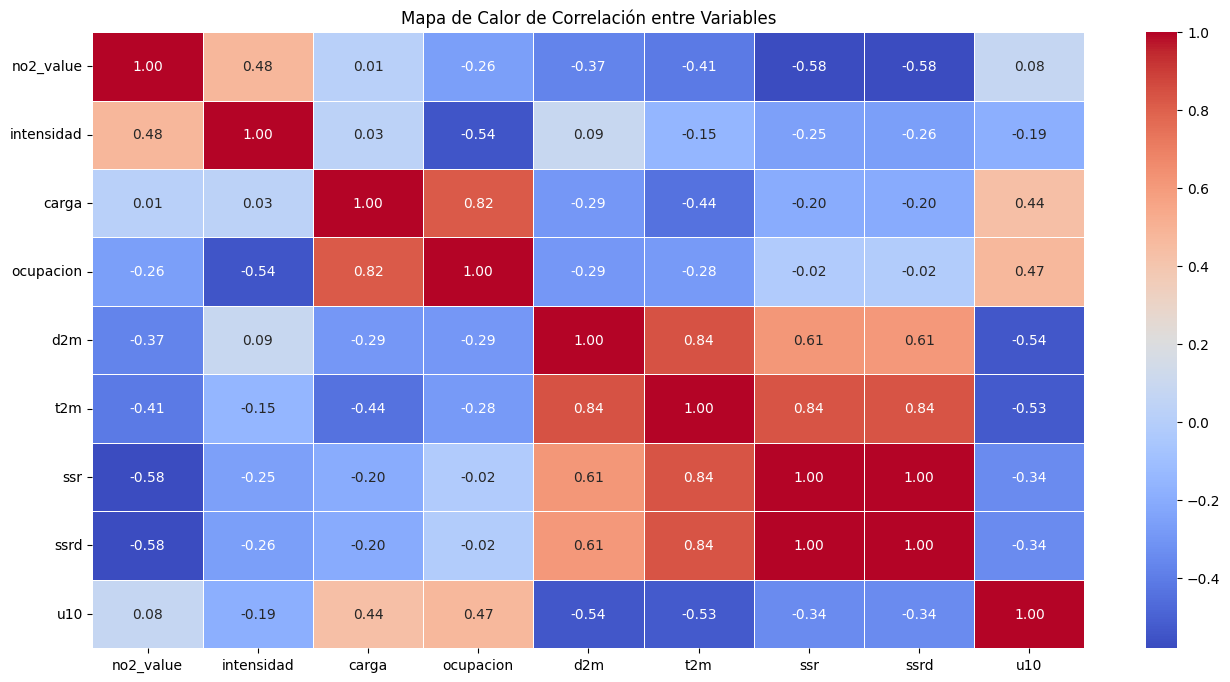

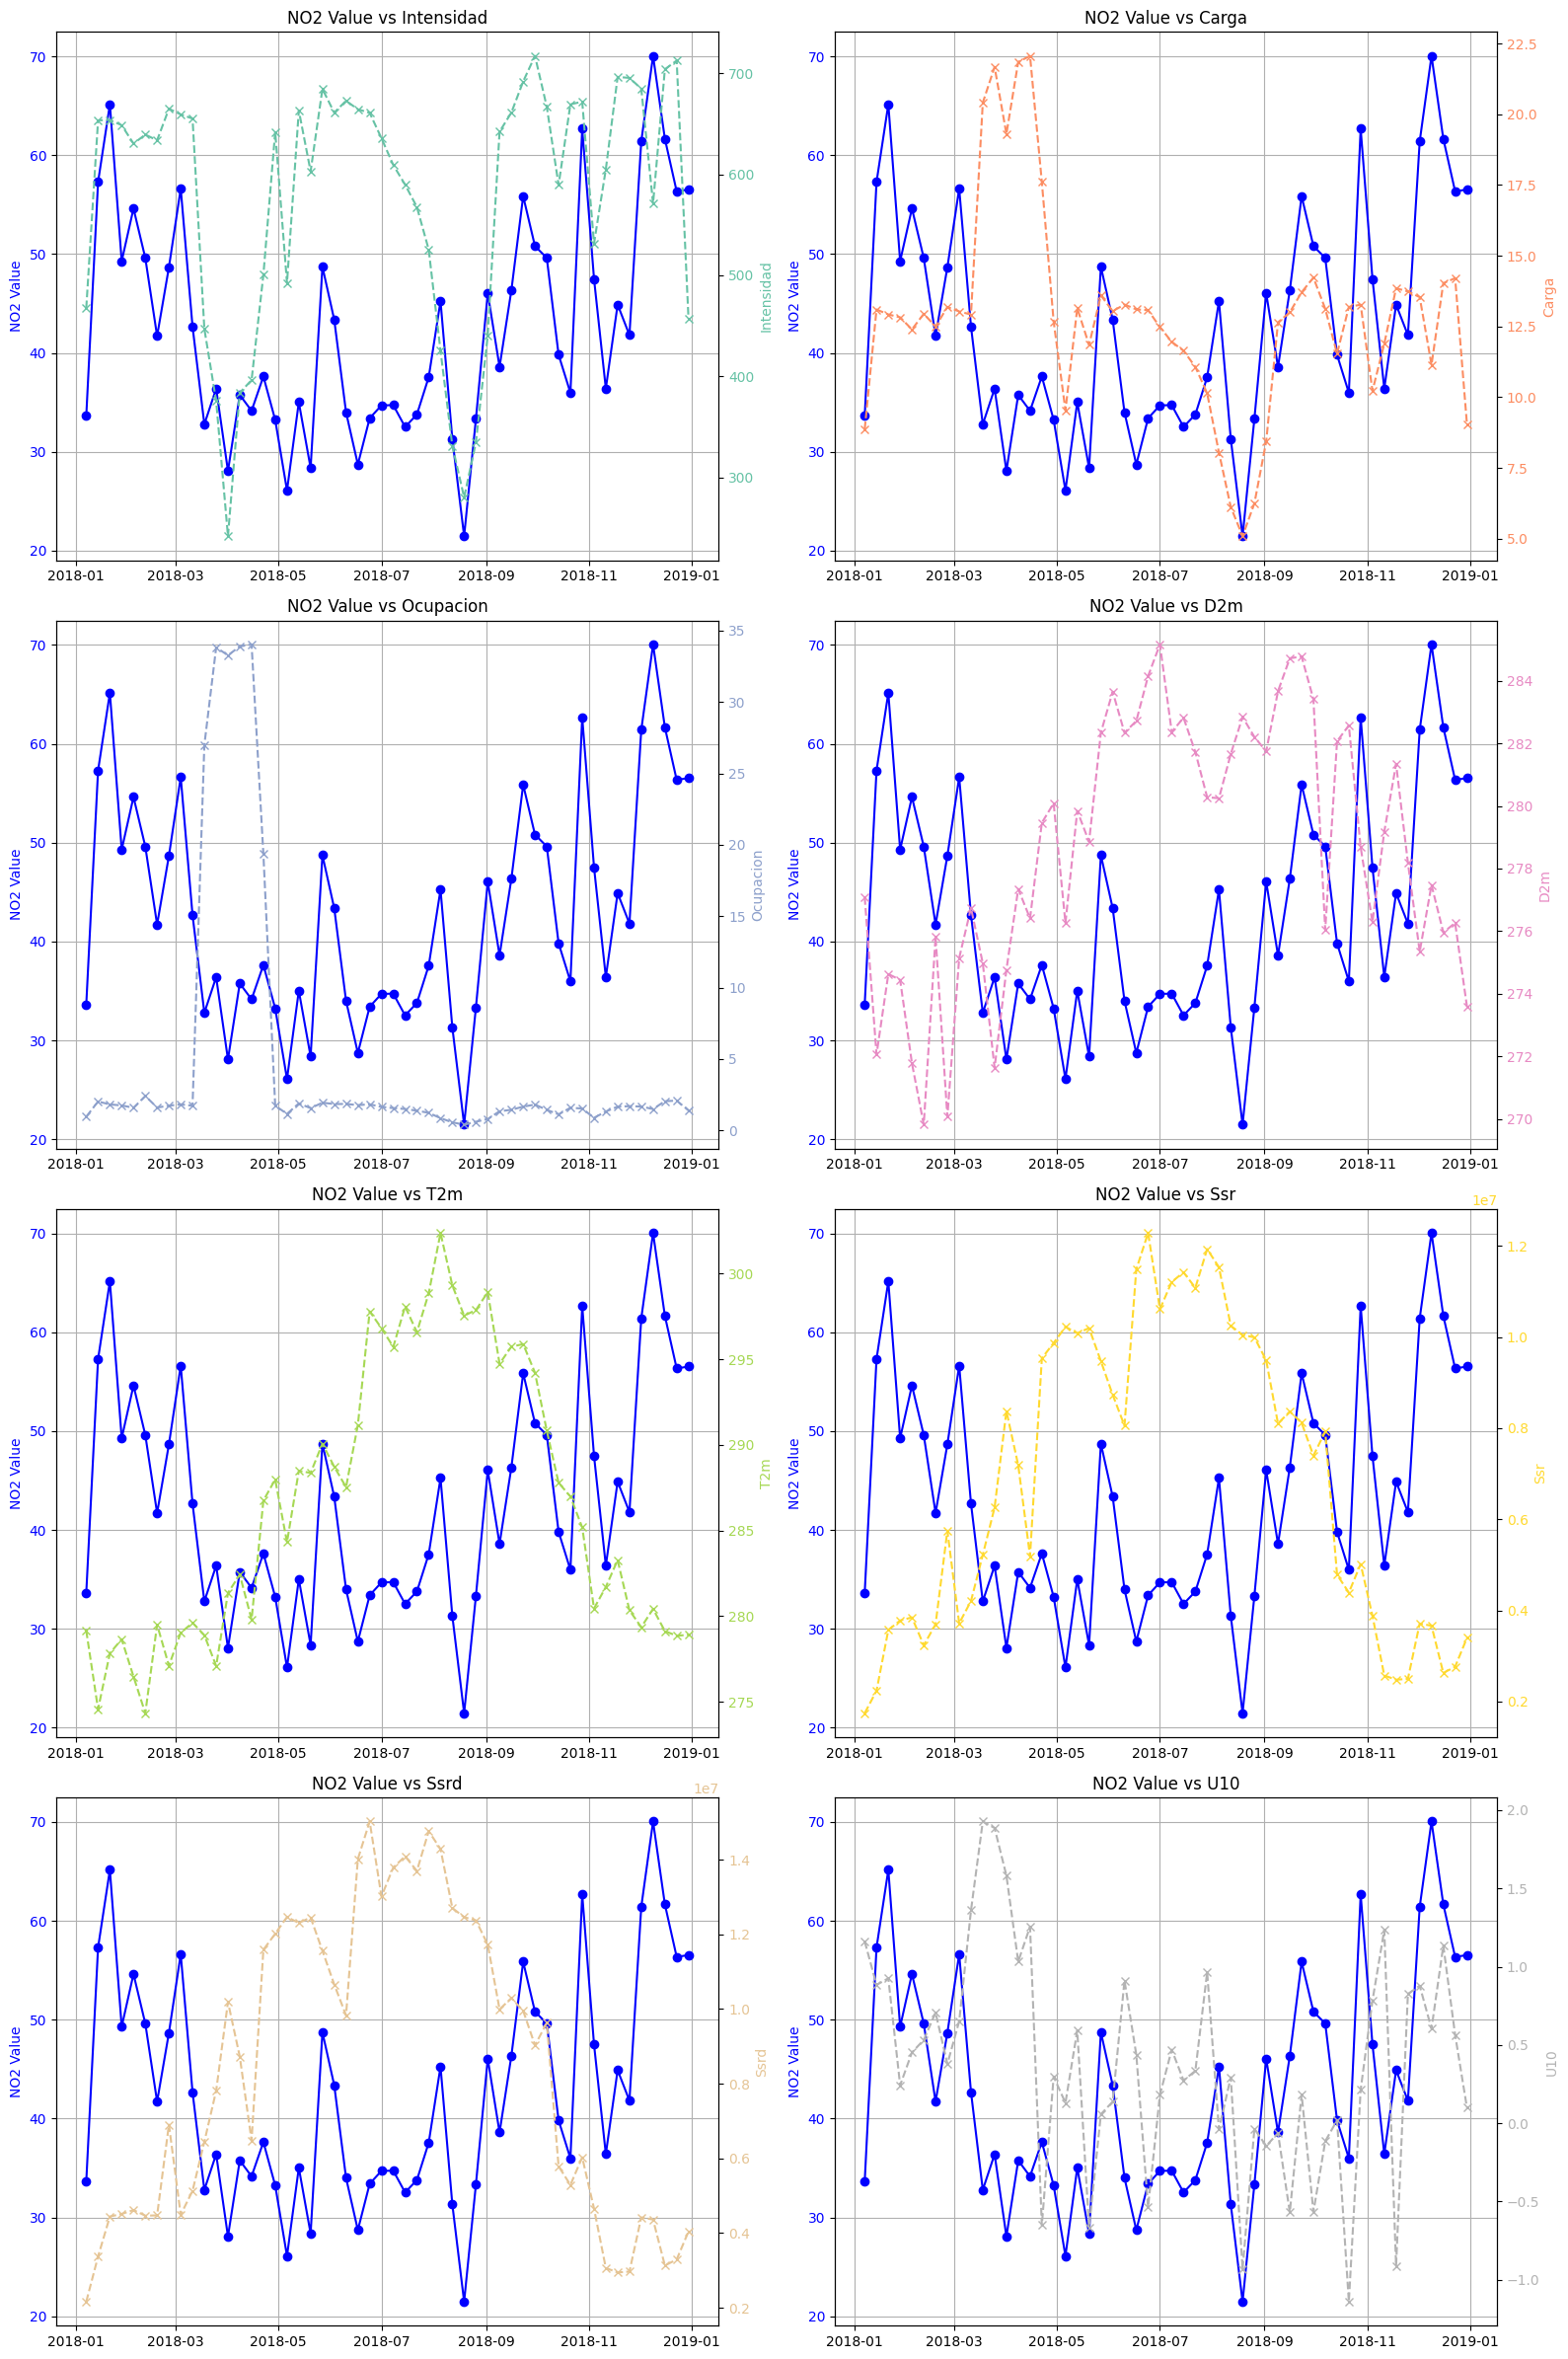

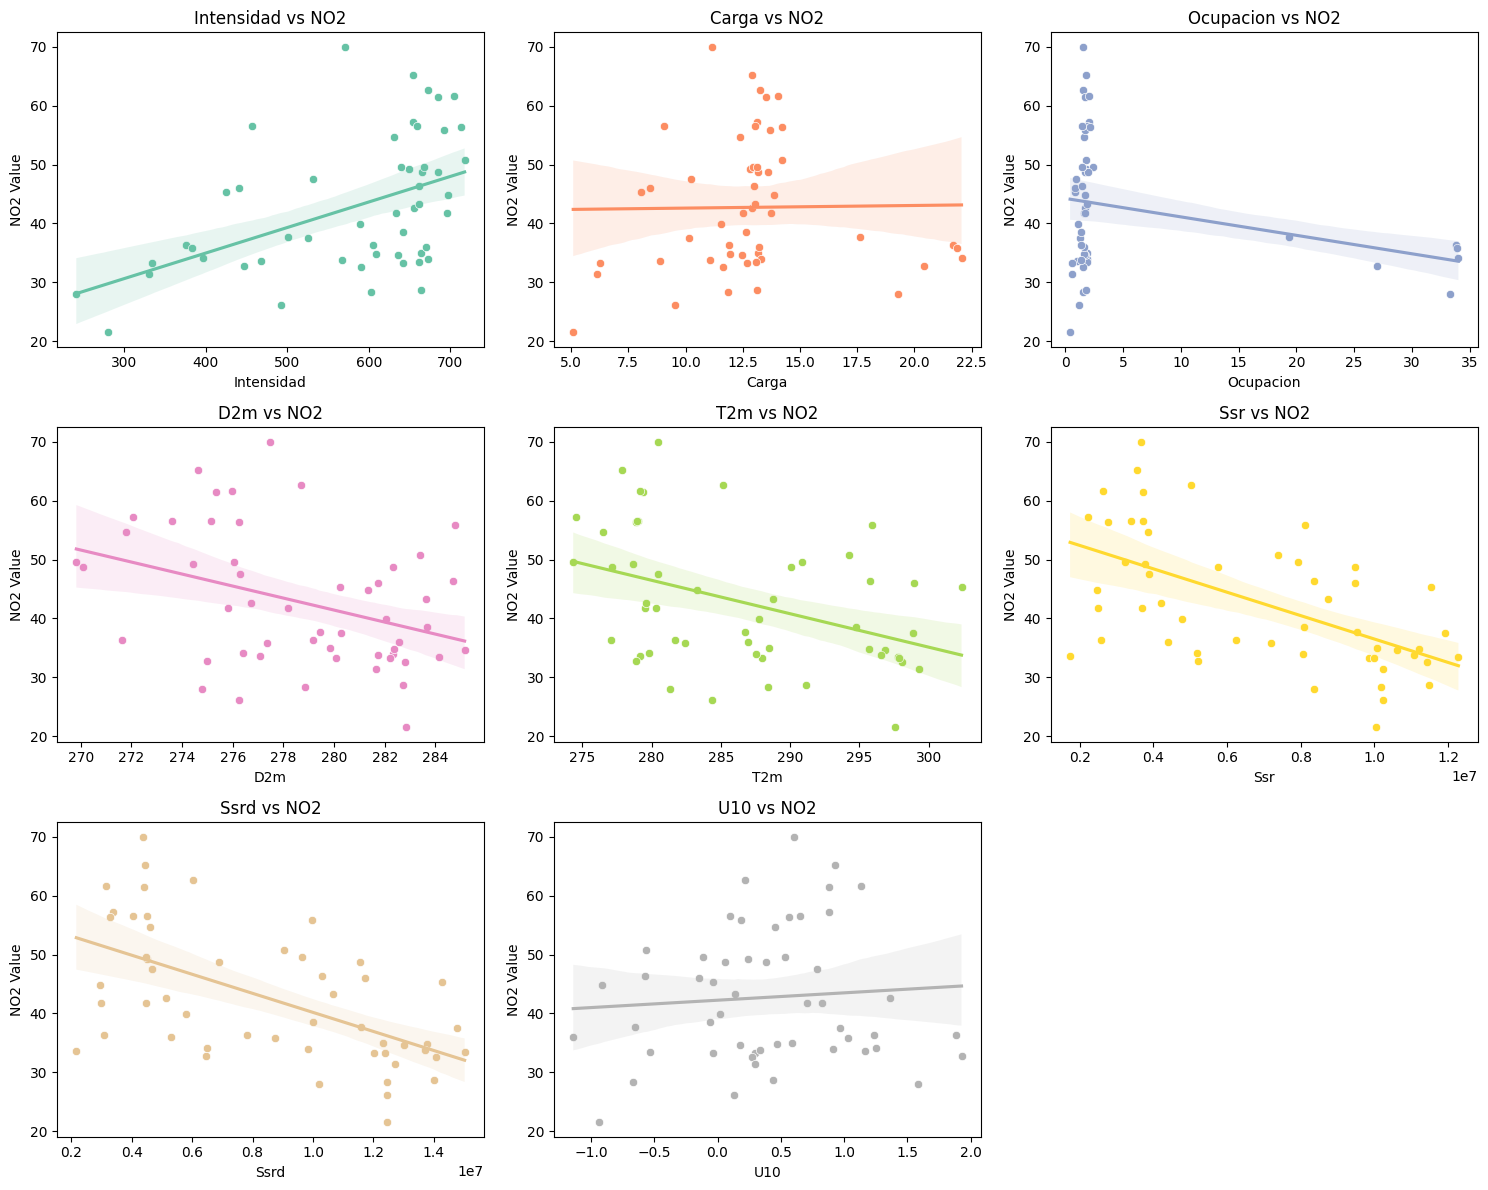

In [19]:
plot_no2(df, '28079011', min_date='2018-01-01', max_date='2018-12-31', freq='W')

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_14088/1618884318.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_agg = df_num.resample(freq).mean()


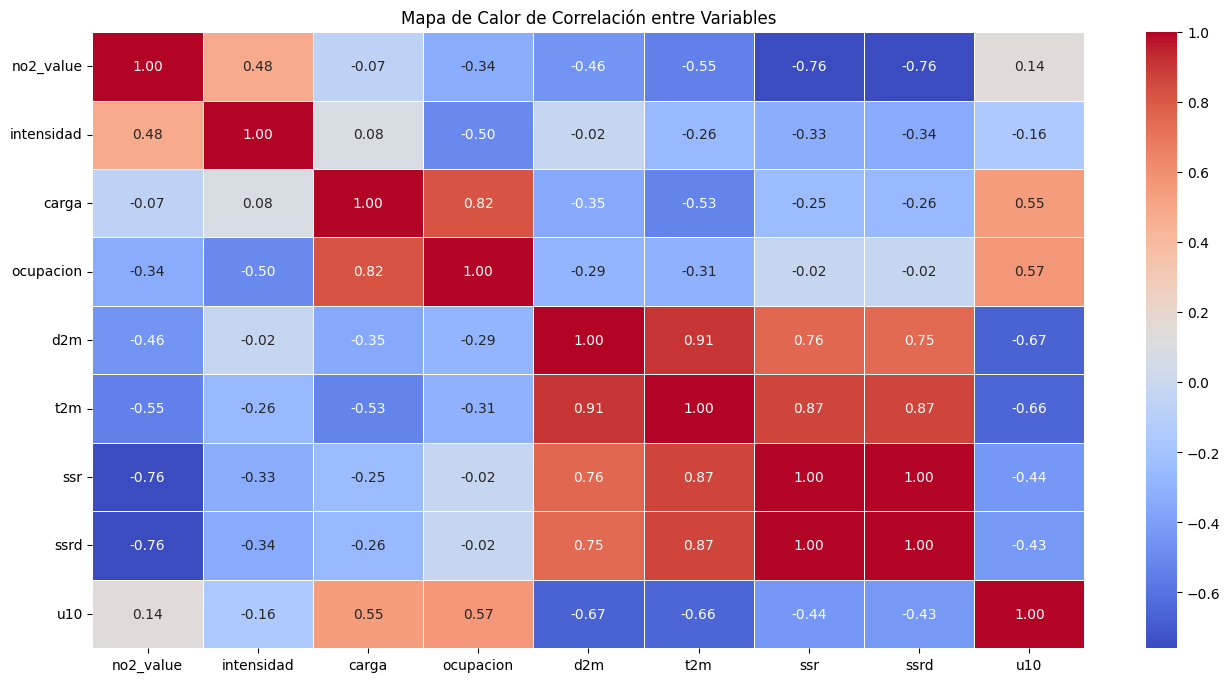

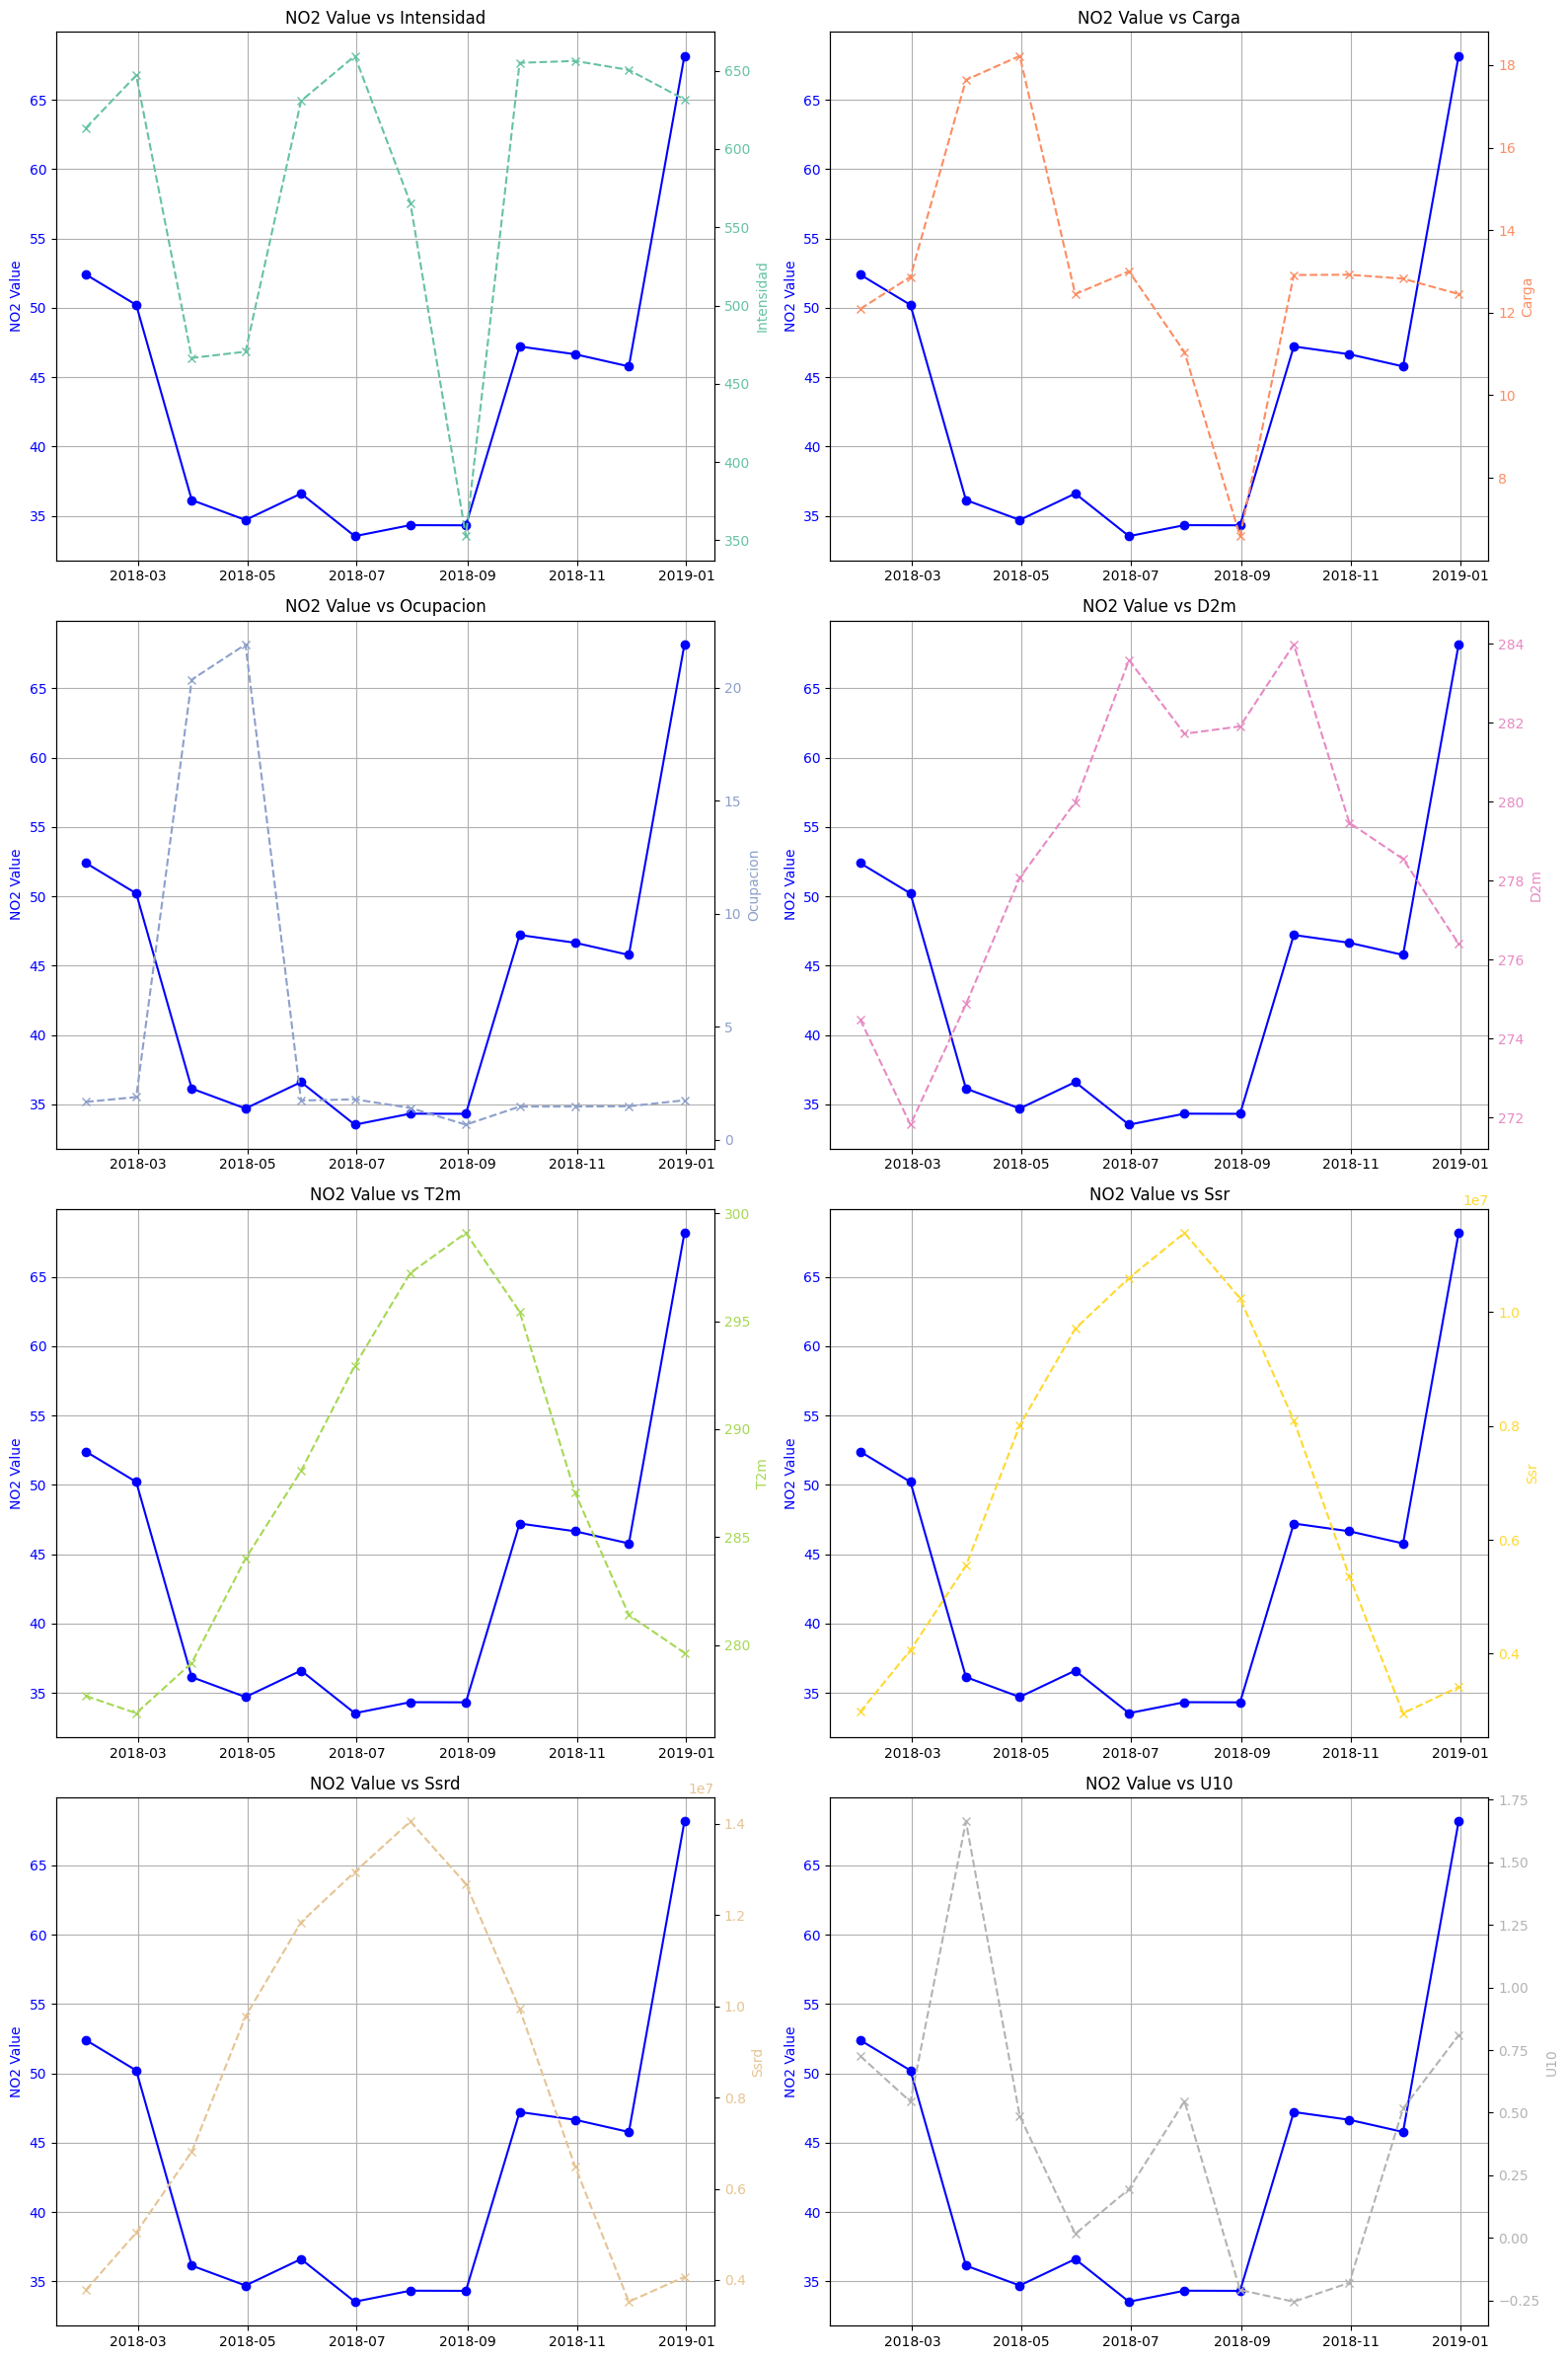

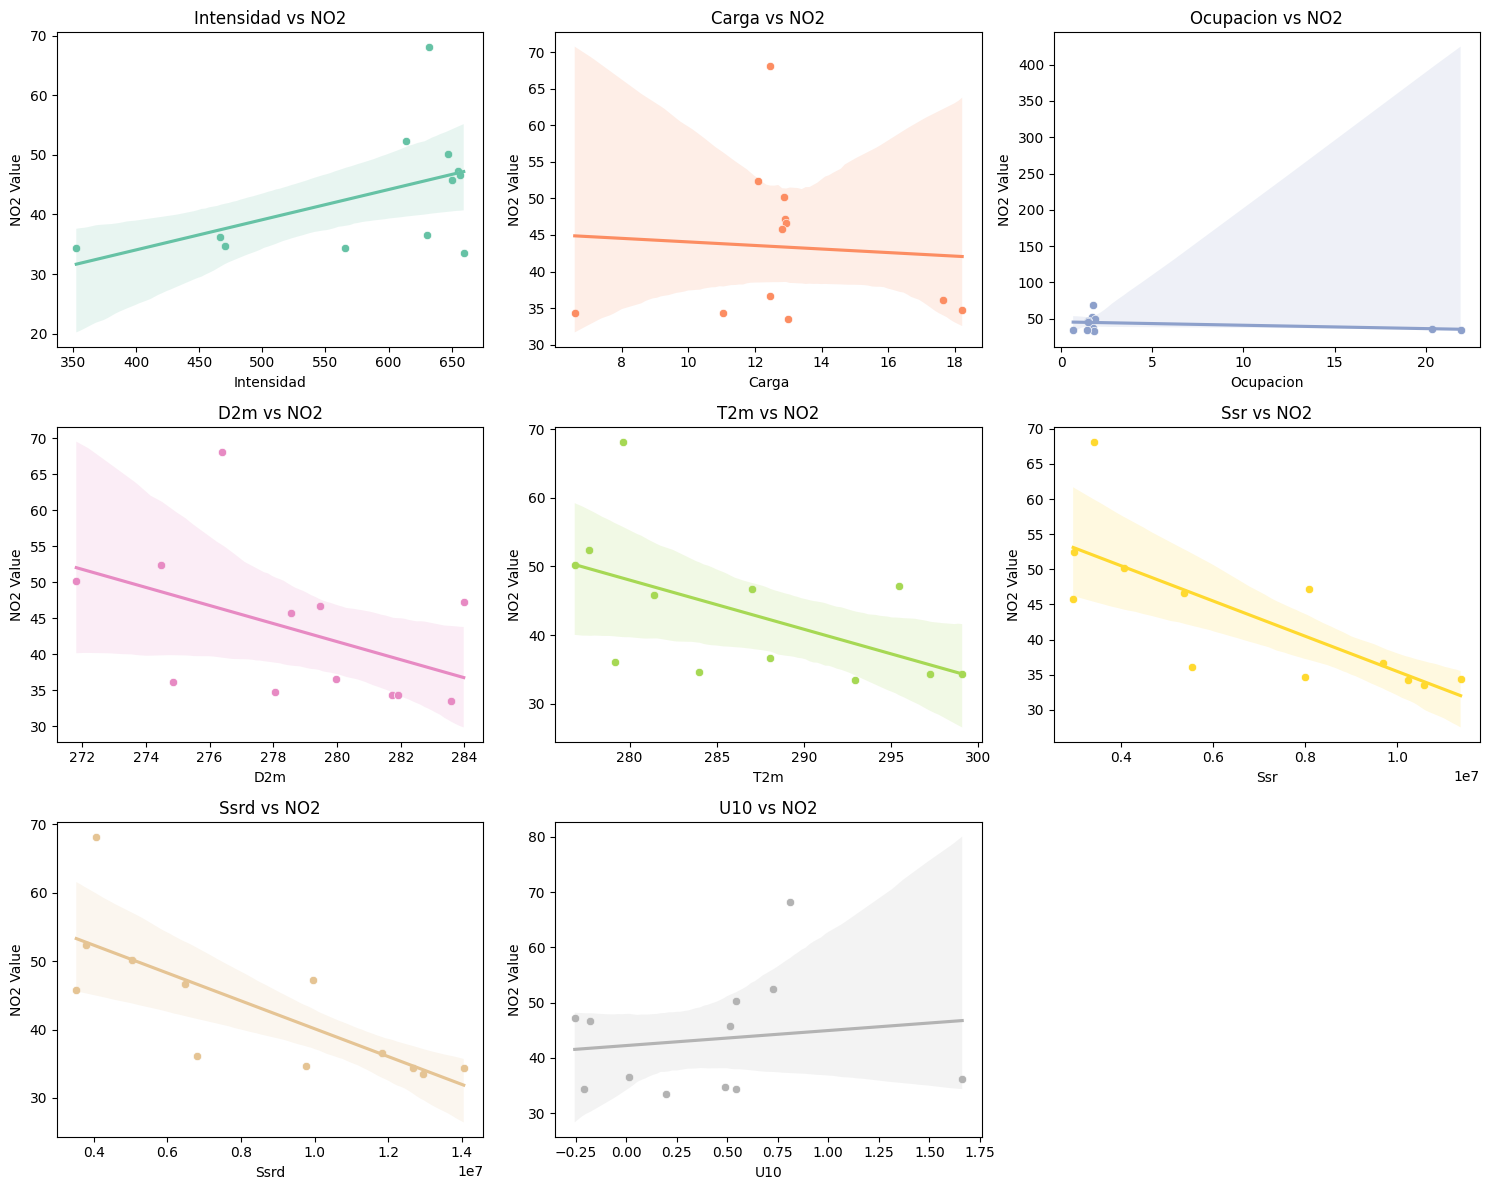

In [20]:
plot_no2(df, '28079011', min_date='2018-01-01', max_date='2018-12-15', freq='M')

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(df, id, min_date, max_date, freq='D'):
    """
    Descompone la serie temporal de NO2 en tendencia, estacionalidad y residuo.

    Parámetros:
    - df: DataFrame con los datos.
    - id: ID de la estación de medición.
    - min_date: Fecha mínima en formato 'YYYY-MM-DD'.
    - max_date: Fecha máxima en formato 'YYYY-MM-DD'.
    - freq: Frecuencia de la descomposición ('D' para diario, 'W' para semanal, 'M' para mensual).
    """
    # Filtrar datos por estación y fechas
    df_filtered = df[df['id_no2'] == id].copy()
    df_filtered['fecha'] = pd.to_datetime(df_filtered['fecha'])
    df_filtered = df_filtered[(df_filtered['fecha'] >= pd.to_datetime(min_date)) & 
                              (df_filtered['fecha'] <= pd.to_datetime(max_date))]
    
    # Asegurar que los datos están indexados por fecha
    df_filtered.set_index('fecha', inplace=True)
    
    # Resample para ajustar la frecuencia y evitar problemas con datos faltantes
    df_resampled = df_filtered['no2_value'].resample(freq).mean()
    
    df_resampled = df_resampled.interpolate(method='linear')
    
    print(df_filtered['no2_value'].groupby(df_filtered.index.date).count())

    print(df_resampled.isna().sum())

    # Aplicar descomposición estacional
    result = seasonal_decompose(df_resampled, model='additive', period=7 if freq == 'D' else 30)
    
    # Graficar resultados
    fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
    result.observed.plot(ax=axes[0], title="Serie Original", color="black")
    result.trend.plot(ax=axes[1], title="Tendencia", color="blue")
    result.seasonal.plot(ax=axes[2], title="Estacionalidad", color="green")
    result.resid.plot(ax=axes[3], title="Ruido (Residuos)", color="red")
    
    plt.tight_layout()
    plt.show()


2018-02-01    24
2018-02-02    24
2018-02-03    24
2018-02-04    24
2018-02-05    24
              ..
2018-11-26    24
2018-11-27    24
2018-11-28    24
2018-11-29    24
2018-11-30     1
Name: no2_value, Length: 298, dtype: int64
0


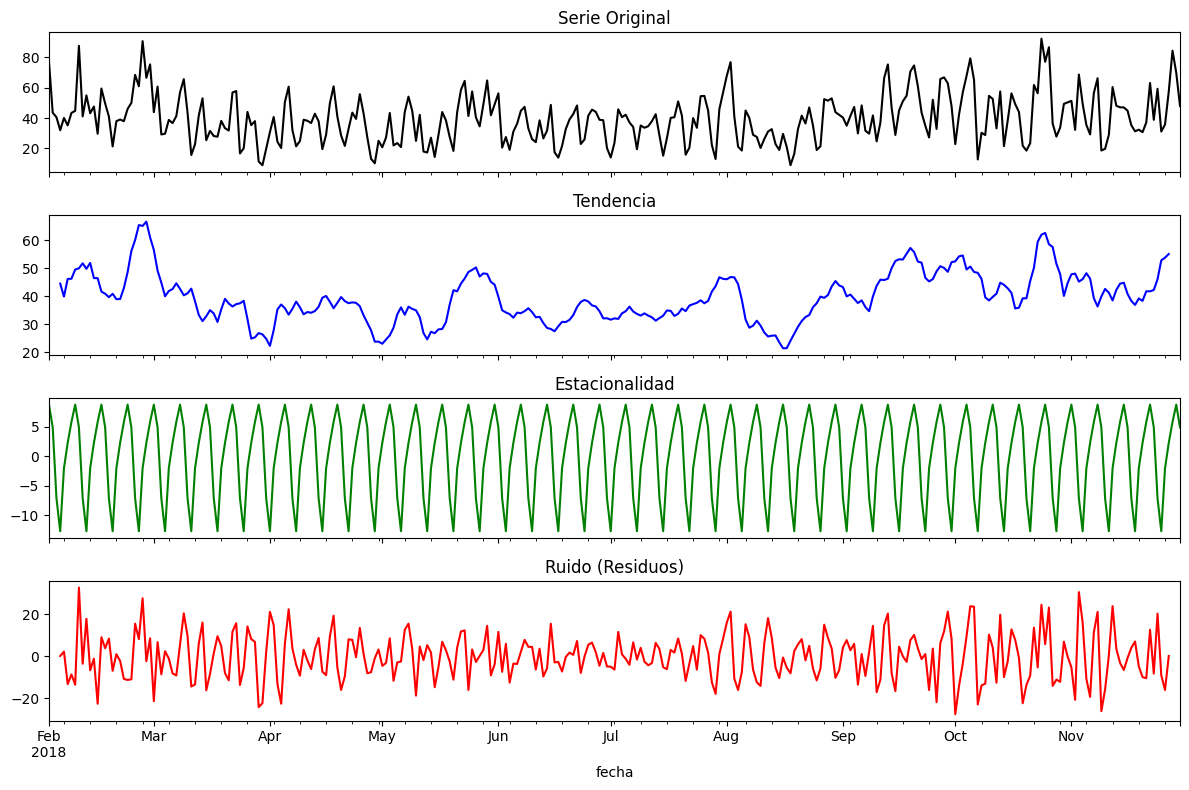

In [22]:
plot_seasonal_decomposition(df, '28079011', min_date='2018-02-01', max_date='2018-11-30', freq='D')


Este gráfico muestra la descomposición estacional de la serie temporal de NO₂ en sus componentes:

1. Serie Original (arriba, negro):

- Fluctuaciones diarias con variabilidad significativa.
- Se observan picos y caídas, lo que indica cambios en la contaminación a lo largo del tiempo.

2. Tendencia (azul, segundo gráfico):

- Muestra una tendencia general con períodos de aumento y disminución.

- Parece haber un ciclo estacional más largo, posiblemente asociado a factores como el clima o el tráfico.

3. Estacionalidad (verde, tercer gráfico):

- Oscilaciones regulares con un patrón repetitivo.

- Indica un ciclo fuerte, posiblemente de 24 horas (dado que la frecuencia usada es diaria).

- Puede reflejar el impacto de patrones de tráfico o actividad humana en la contaminación.

4. Ruido o residuos (rojo, abajo):

- Representa las variaciones que no son explicadas por la tendencia ni la estacionalidad.

- Parece mostrar más variabilidad en algunos períodos, lo que puede indicar eventos anómalos o días con factores externos influyentes.

🔍 ¿Qué conclusiones puedes sacar?
- ✅ La serie tiene un patrón estacional claro, lo que significa que los niveles de NO₂ siguen un ciclo regular.
- ✅ La tendencia no es completamente lineal, lo que sugiere que hay factores a largo plazo afectando la contaminación.
- ✅ El ruido parece significativo, lo que podría indicar la necesidad de un modelo más robusto que capture mejor la variabilidad.

Si estás pensando en modelar la serie, te recomendaría probar:

- SARIMA o Prophet si quieres modelar tendencia + estacionalidad.
- Modelos de Machine Learning con variables exógenas (meteorología, tráfico).
- Filtrar más el ruido o identificar eventos anómalos.

¿Qué quieres analizar a partir de esto? 🚀

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_14088/3104295040.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['hour'], y=df['no2_value'], palette="coolwarm")


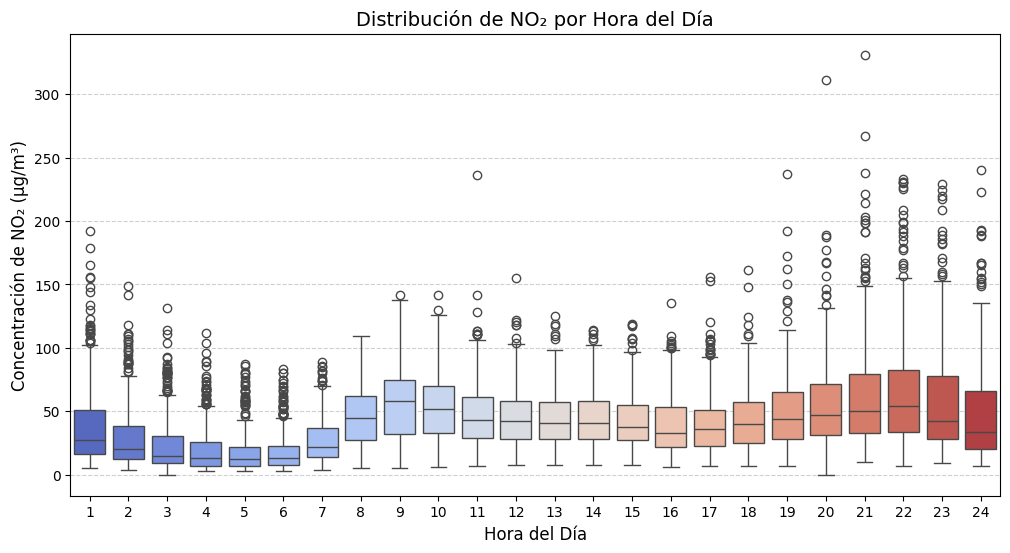

/var/folders/kc/t6c9n8gj7mbblj0w7sy3ykwm0000gn/T/ipykernel_14088/3104295040.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df['day_of_week'], y=df['no2_value'], order=order, palette="viridis")


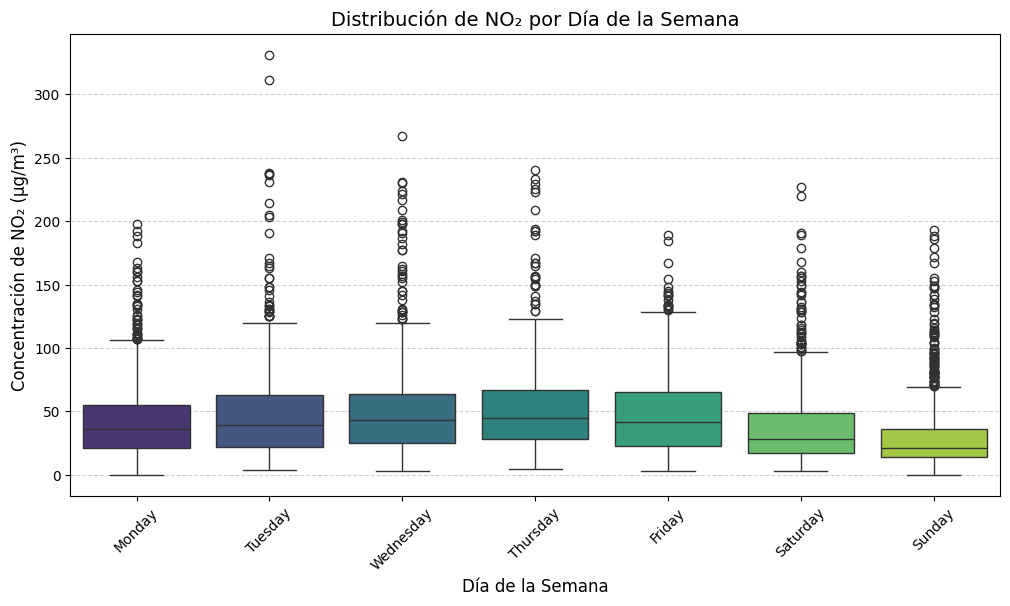

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_no2_hourly_distribution(df):
    """
    Genera un boxplot para analizar la distribución de NO₂ por hora del día.
    """
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['hour'], y=df['no2_value'], palette="coolwarm")
    
    plt.title('Distribución de NO₂ por Hora del Día', fontsize=14)
    plt.xlabel('Hora del Día', fontsize=12)
    plt.ylabel('Concentración de NO₂ (µg/m³)', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

def plot_no2_weekly_distribution(df):
    """
    Genera un boxplot para analizar la distribución de NO₂ por día de la semana.
    """
    # Aseguramos que 'fecha' sea datetime
    df['fecha'] = pd.to_datetime(df['fecha'])
    df['day_of_week'] = df['fecha'].dt.day_name()

    # Ordenamos los días correctamente
    order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df['day_of_week'], y=df['no2_value'], order=order, palette="viridis")
    
    plt.title('Distribución de NO₂ por Día de la Semana', fontsize=14)
    plt.xlabel('Día de la Semana', fontsize=12)
    plt.ylabel('Concentración de NO₂ (µg/m³)', fontsize=12)
    
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.show()

# Llamamos a las funciones para analizar la data
plot_no2_hourly_distribution(df)
plot_no2_weekly_distribution(df)


In [24]:
import folium
from folium.plugins import HeatMap


def plot_no2_map(df):
    # Filtrar nulos y normalizar valores
    df = df.dropna(subset=['no2_value']).copy()
    df['no2_norm'] = df['no2_value'] / df['no2_value'].max()

    # Centro del mapa basado en las coordenadas promedio
    map_center = [df['latitud'].mean(), df['longitud'].mean()]
    my_map = folium.Map(location=map_center, zoom_start=12)

    # Crear el mapa de calor
    heat_data = df[['latitud', 'longitud', 'no2_norm']].values.tolist()
    HeatMap(heat_data, radius=12, blur=15).add_to(my_map)

    # Añadir marcadores de estaciones de medición
    for _, row in df.iterrows():
        folium.Marker(
            location=[row['latitud'], row['longitud']],
            popup=f"NO₂: {row['no2_value']:.2f} µg/m³",
            icon=folium.Icon(color="blue", icon="cloud")
        ).add_to(my_map)

    return my_map


# Normalizar los valores de NO₂ para mejorar la visualización del HeatMap:
df['no2_norm'] = df['no2_value'] / df['no2_value'].max()
# plot_no2_map(df)


<Figure size 1200x500 with 0 Axes>

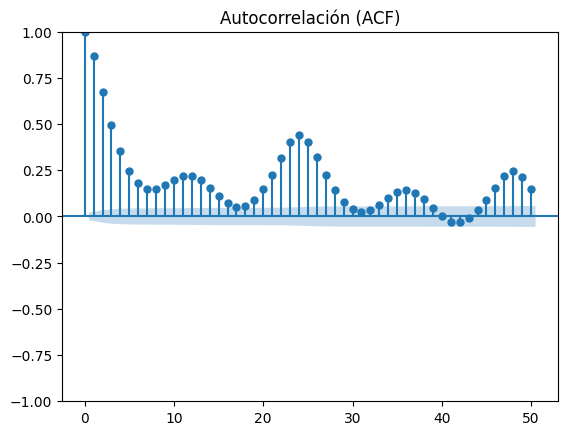

<Figure size 1200x500 with 0 Axes>

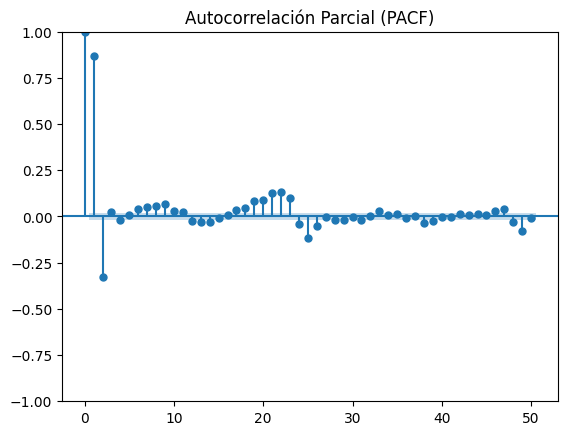

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))
plot_acf(df['no2_value'].dropna(), lags=50)
plt.title("Autocorrelación (ACF)")
plt.show()

plt.figure(figsize=(12, 5))
plot_pacf(df['no2_value'].dropna(), lags=50)
plt.title("Autocorrelación Parcial (PACF)")
plt.show()
